Lecture: AI I - Advanced 

Previous:
[**Chapter 2.1: Regularization**](../02_training/01_regularization.ipynb)

---

# Chapter 2.2: Hyperparameter Tuning

In the previous section, you learned various regularization techniques to prevent overfitting—dropout, batch normalization, early stopping, and weight decay. But each technique introduced new hyperparameters: What dropout rate should you use? How much weight decay? You probably chose values like 0.3 or 0.01 somewhat arbitrarily, perhaps based on common defaults. Now comes the question: How do you find the optimal configuration among thousands of possible combinations?

This is where **hyperparameter tuning** becomes essential. Instead of guessing or manually trying different values, we'll use systematic search algorithms to explore the hyperparameter space efficiently and find configurations that maximize our model's performance.

## What Are Hyperparameters?

**Hyperparameters** are configuration settings that you choose before training begins—they control the learning process itself, unlike model parameters (weights and biases) which are learned during training. Choosing good hyperparameters can mean the difference between a model that achieves 70% accuracy and one that reaches 95%.

## Hyperparameters can include:
### 1. Optimizer and Learning Rate

The **optimizer** determines how weights are updated (SGD, Adam, RMSprop), while the **learning rate** controls the step size. This is often the most critical hyperparameter—too high and training diverges, too low and learning is painfully slow. Learning rates typically range from $1e-5$ to $1e-1$ and are best searched on a logarithmic scale (since 0.001 to 0.01 is as significant a change as 0.01 to 0.1).

**Search strategy**: Log-uniform distribution <br>
**Typical range**: 1e-5 to 1e-1

### 2. Loss Function

For classification, you'll typically use CrossEntropyLoss, while regression uses MSELoss or L1Loss. The choice depends on your task rather than being a tunable parameter, though in some cases (e.g., imbalanced classification) you might compare weighted vs. unweighted loss functions.

**Search strategy**: Usually fixed by task, occasionally categorical choice

### 3. Epochs

The number of training iterations through the entire dataset. Too few epochs and your model underfits; too many and you waste time or overfit (though early stopping mitigates this). Modern practice often uses a high max_epochs with early stopping rather than tuning this directly.

**Search strategy**: Usually fixed with early stopping, occasionally discrete <br>  
**Typical range**: 50-500

### 4. Batch Size

How many samples are processed before updating weights. Smaller batches (16-32) add noise that can help generalization but slow training; larger batches (128-256) are faster but may converge to sharper minima. Batch size also interacts with learning rate—larger batches often need higher learning rates.

**Search strategy**: Categorical choice (powers of 2) <br>
**Typical values**: [16, 32, 64, 128]

### 6. Per-Layer Configuration

Each layer can have different settings:
- **Activation function**: ReLU is standard, but Leaky ReLU, ELU, or GELU might work better for specific tasks
- **Neuron count (hidden dimensions)**: Typically powers of 2 (32, 64, 128, 256, 512) for computational efficiency
- **Regularization parameters** (dropout rate, initialization) can also vary per layer

**Search strategy**: Categorical (activation) or discrete/categorical (neuron count)

### 7. Architecture

**Depth** (number of layers) and **shape** (how dimensions change between layers—pyramid, constant, hourglass):
- **Shallow networks (1-2 hidden layers)**: Simpler, less prone to overfitting, limited capacity
- **Deep networks (3+ hidden layers)**: More expressive, can learn hierarchical features, harder to train

**Search strategy**: Discrete (number of layers) + continuous/discrete (dimension pattern)

## Search Strategy

**Random search** tries random combinations—simple but inefficient. Grid search is systematic but exponentially expensive (3 values for 5 hyperparameters = 3^5 = 243 trials!).

**Bayesian optimization** is smarter: it builds a probabilistic model of how hyperparameters affect performance, then uses this model to suggest promising configurations. After each trial, it updates its belief about which regions of the hyperparameter space are worth exploring. This means it finds good configurations in far fewer trials than random or grid search.

**Optuna** implements several Bayesian optimization algorithms, with **Tree-structured Parzen Estimator (TPE)** as the default. Think of it as learning from experience: "High learning rates with small batch sizes performed poorly, so let's try lower learning rates next."

## Hyperparameter Tuning with Optuna

In [1]:
import torch

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)  # set random seed for reproducibility

iris = datasets.load_iris()
x = iris.data  # 4 features: sepal length, sepal width, petal length, petal width
y = iris.target  # 3 classes: setosa, versicolor, virginica

x_scaled = StandardScaler().fit_transform(x)
x_train, x_temp, y_train, y_temp = train_test_split(
    x_scaled, y, test_size=0.4, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

batch_size = 16
train_loader = DataLoader(TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val)), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test)), batch_size=batch_size)

### Flexible Model Architecture 

In [2]:
import torch.nn as nn

class FlexibleClassifier(nn.Module):
    """
    Flexible neural network that can be configured with different architectures.
    Supports variable depth and layer dimensions.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        """
        Args:
            input_dim: Number of input features
            hidden_dims: List of hidden layer dimensions, e.g., [64, 32]
            output_dim: Number of output classes
            dropout_rate: Dropout probability
        """
        super().__init__()
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [4]:
import optuna

def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion):
    """Evaluate the model"""
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            eval_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    avg_loss = eval_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.01, weight_decay=0.0, patience=15, trial=None):
    """Complete training loop"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer) # Train
        val_loss, val_acc = evaluate(model, val_loader, criterion)  # Validate
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
        if trial is not None:
            trial.report(val_acc, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    return best_val_acc, best_epoch

### Objective Function

In [5]:
def objective(trial):
    """
    Objective function for Optuna to optimize.
    Returns the best validation accuracy for this hyperparameter configuration.
    """
    # Define the search space
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_dims = []
    for i in range(n_layers):
        dim = trial.suggest_categorical(f'hidden_dim_layer_{i}', [32, 64, 128, 256])
        hidden_dims.append(dim)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)    
    
    # Training the model with the sampled hyperparameters
    model = FlexibleClassifier(input_dim=4,hidden_dims=hidden_dims,output_dim=3,dropout_rate=dropout_rate)        
    best_val_acc, best_epoch = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=learning_rate,
        weight_decay=weight_decay,
        trial=trial  # For Optuna pruning
    )
    
    return best_val_acc

### Run Optimization

In [6]:
study = optuna.create_study(
    direction='maximize',
    study_name='iris_classification',
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10
    )
)

n_trials = 50
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2026-01-01 12:22:58,393] A new study created in memory with name: iris_classification


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-01 12:23:00,134] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_layers': 3, 'hidden_dim_layer_0': 128, 'hidden_dim_layer_1': 32, 'hidden_dim_layer_2': 128, 'weight_decay': 0.00017521385419341513, 'learning_rate': 1.5014294676988676e-05, 'dropout_rate': 0.15151730828178306}. Best is trial 0 with value: 0.6666666666666666.
[I 2026-01-01 12:23:00,232] Trial 1 finished with value: 0.8666666666666667 and parameters: {'n_layers': 2, 'hidden_dim_layer_0': 32, 'hidden_dim_layer_1': 64, 'weight_decay': 1.2968865790865804e-05, 'learning_rate': 7.389379112502169e-05, 'dropout_rate': 0.1183884609885662}. Best is trial 1 with value: 0.8666666666666667.
[I 2026-01-01 12:23:00,351] Trial 2 finished with value: 0.7666666666666667 and parameters: {'n_layers': 2, 'hidden_dim_layer_0': 256, 'hidden_dim_layer_1': 64, 'weight_decay': 0.0027702092908288923, 'learning_rate': 0.00017215312095741434, 'dropout_rate': 0.24284535046588496}. Best is trial 1 with value: 0.86666666666

### Best Model

In [9]:
best_params = study.best_trial.params

n_layers = best_params['n_layers']
hidden_dims = [best_params[f'hidden_dim_layer_{i}'] for i in range(n_layers)]

best_model = FlexibleClassifier(
    input_dim=4,
    hidden_dims=hidden_dims,
    output_dim=3,
    dropout_rate=best_params['dropout_rate']
)

best_val_acc, _ = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay'],
)

print(f"  Best validation accuracy: {best_val_acc:.4f}")

  Best validation accuracy: 1.0000


### Evaluation

In [ ]:
from sklearn.metrics import classification_report

best_model.eval()
with torch.no_grad():
    test_outputs = best_model(torch.FloatTensor(x_test))
    _, y_pred = torch.max(test_outputs, 1)


print(classification_report(y_test, y_pred.numpy(), target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.71      1.00      0.83        10
   virginica       1.00      0.60      0.75        10

    accuracy                           0.87        30
   macro avg       0.90      0.87      0.86        30
weighted avg       0.90      0.87      0.86        30



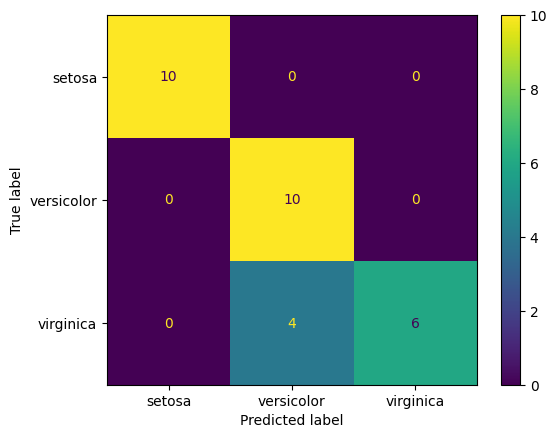

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.numpy(), display_labels=iris.target_names)

---

Lecture: AI I - Advanced 

Exercise: [**Exercise 2.2: Hyperparameter Tuning**](../02_training/exercises/02_optimization.ipynb)

Next: [**Chapter 2.3: Ensemble Learning**](../02_training/03_ensemble.ipynb)